In [1]:
#Cargo paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

### Cargo Items Dataset

In [2]:
items_dataset_filename= 'items_featselected.csv.gz'


items = pd.read_csv(items_dataset_filename)

/Users/juanfrittaoni/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#elimino registros con sold_quantity missing
items.dropna(subset=['sold_quantity'], inplace=True)

#### Muestra
Decido trabajar con una muestra del dataset debido a la capacidad de procesamiento de mi computadora local

In [4]:
trabajar_con_muestra = True

frac_muestra = 0.8


In [5]:
if trabajar_con_muestra:
    items = items.sample(frac = frac_muestra, random_state= 42)

### Análisis uni-bivariado de la variable target

In [6]:
print('Valores más comunes de sold_quantity')
items.sold_quantity.value_counts()[0:10]

Valores más comunes de sold_quantity


0.0      69707
5.0      42851
25.0     18549
50.0     18099
1.0      16973
2.0      10580
250.0    10322
500.0    10158
100.0     9693
3.0       7465
150.0     6444
4.0       6267
200.0     4549
10.0      1757
Name: sold_quantity, dtype: int64

In [7]:
print('Medidas de resumen de sold_quantity')
items.sold_quantity.describe()

Medidas de resumen de sold_quantity


count    262064.000000
mean         76.476914
std         427.281812
min           0.000000
25%           0.000000
50%           5.000000
75%          50.000000
max       50000.000000
Name: sold_quantity, dtype: float64

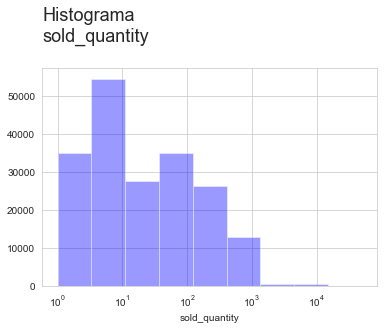

In [8]:
figsize=(7, 5)
sns.set_style('whitegrid')
LogMin, LogMax = np.log10(1),np.log10(items.sold_quantity.max())
newBins = np.logspace(LogMin, LogMax,10)
#sns.distplot(df['GDP (BILLIONS)'].values,bins=newBins,kde=False,ax=ax[1])
ax = sns.distplot(items.sold_quantity,bins=newBins,kde=False, color="blue")
ax.set_xscale('log')

title = 'Histograma\nsold_quantity\n'
plt.title(title, loc='left', fontsize=18)
plt.show()


Mediante el histograma podemos observar que la variable target no tiene una distribución normal sino que es asimetrica con una cola pasada a la derecha, siguiendo una forma tipo $Chi^2$. Esto se corresponde con el hecho de que el media sea mayor que la mediana

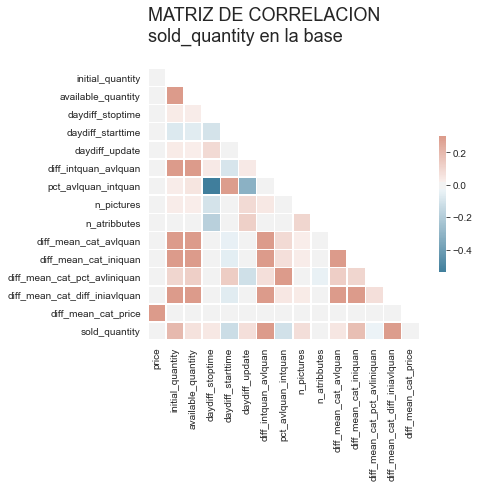

In [9]:
# Calculo la matrix de correlación para las variables numéricas
num_features = ['price', 'initial_quantity', 'available_quantity',
                'daydiff_stoptime', 'daydiff_starttime', 'daydiff_update',
                'diff_intquan_avlquan', 'pct_avlquan_intquan',
                'n_pictures', 'n_atribbutes', 'diff_mean_cat_avlquan',
                'diff_mean_cat_iniquan', 'diff_mean_cat_pct_avliniquan',
                'diff_mean_cat_diff_iniavlquan', 'diff_mean_cat_price', 'sold_quantity']

corr = items[num_features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
mask = mask[1:, :-1]
corr = corr.iloc[1:,:-1].copy()

f, ax = plt.subplots(figsize=(7, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
title = 'MATRIZ DE CORRELACION \nsold_quantity en la base\n'
plt.title(title, loc='left', fontsize=18)
plt.show()

Observamos que la variable target correlaciona positivamente, como era de esperarse, con *diff_intquan_avlquan* y *diff_mean_cat_diff_iniavlquan*, ambas variables contruidas a partir de la diferencia entre la cantidad inicial y la cantidad disponible del producto. Sin embargo, el valor de la correlación dista de ser elevado, al rededor del 0.2

In [10]:
features = ['price', 'initial_quantity', 'available_quantity',
                   'listing_type_id','condition', 'status', 'categoria_id',
                   'flg_descuento', 'flg_official_store', 'flg_brand_verified',
                   'daydiff_stoptime', 'daydiff_starttime', 'daydiff_update', 'provincia',
                   'freeshipping', 'diff_intquan_avlquan', 'pct_avlquan_intquan',
                   'n_pictures', 'n_atribbutes', 'diff_mean_cat_avlquan',
                   'diff_mean_cat_iniquan', 'diff_mean_cat_pct_avliniquan',
                   'diff_mean_cat_diff_iniavlquan', 'diff_mean_cat_price']

X= items[features]
y=items.sold_quantity

In [11]:
#Divido el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

In [12]:
#divido train nuevamente para tener trainset y validationset
X_subtrain, X_valid, y_subtrain, y_valid = train_test_split(X_train,y_train,test_size=0.3,random_state=1)

In [13]:
#genero una muestra para optimizar hiperparámetros
X_subtrain_sample = X_subtrain.sample(frac = 0.3)
y_subtrain_sample = y_subtrain.loc[X_subtrain_sample.index]


## Modelos

In [14]:
#función auxilair para metricas: r2 y mean_squared_error, ambas métricas tradicionales para problemas de regresión.
#Cabe aclarar que a la hora de optimizar hiperparametros se tendrá solo encuenta r2
def metricas(y_true, y_pred, nombre_modelo):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rv = pd.DataFrame(pd.Series({'r2': r2, 'mse': mse})).T.rename(index = {0: nombre_modelo})
    return rv

In [15]:
#genero dataset para ir guardando las métricas de los distintos modelos
metricas_modelos = pd.DataFrame()

### Modelo 0: Promedio
Modelo baseline, cabe esperar el su $R^2$ sea 0 ya que por definición ese es el score para un modelo constante

In [16]:
promedio = np.repeat(y_subtrain.mean(), len(y_valid), axis=0)
metricas_modelos= metricas_modelos.append(metricas(y_valid, promedio, '0.Promedio'))

### Modelo 1: ElasticNet con RandomSearch
Regresión lineal con regularización combinada de Lasso y Ridge: https://scikit-learn.org/stable/modules/linear_model.html#elastic-net

In [17]:
#prepocesamiento
#Preprocesamiento para variables numericas: Imputación por media y scalar
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.values.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#Preprocesamiento para variables categóricas: Imputación por moda y creacion de dummies por categoria
categorical_features = X.select_dtypes(include=['object']).columns.values.tolist()
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
        
        
#modelo: Elastic Net 

model = ElasticNet(random_state=42)

#Defino el pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('reg', model)])

#hiperparametros a optimizar mediante Random Search
alphas = [1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
      1.e+02, 1.e+03, 1.e+04]
l1_ratios = [0, 0.25, .5, .75, 1]
random_grid = {'reg__alpha':alphas,
              'reg__l1_ratio':l1_ratios}

#seteo RandomSearch
search_en = RandomizedSearchCV(estimator = pipe, param_distributions = random_grid, 
                n_iter = 5, cv =3, verbose=2, random_state=42, n_jobs = -1)

#entreno
search_en.fit(X_subtrain_sample, y_subtrain_sample)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.6min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['price',
                                                                                'initial_quantity',
                                                                                'available_quantity',
                                                                           

In [18]:
#Guardo el modelo con los hiperparametros que mejor r2_score tuvieron
modelo_final_elasticnet = search_en.best_estimator_

#entreno con todo el trainset y predigo en validationset
modelo_final_elasticnet.fit(X_subtrain, y_subtrain)
y_pred_elasticnet = modelo_final_elasticnet.predict(X_valid)

#guardo 
metricas_modelos = metricas_modelos.append(metricas(y_valid,y_pred_elasticnet, '1.ElasticNet'))
                        

### Modelo 2: RandomForest con RandomSearch
Ensamble de arboles de desición: https://scikit-learn.org/stable/modules/ensemble.html#forest

In [19]:
#prepocesamiento
#Preprocesamiento para variables numericas: Imputación por media y scalar
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.values.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#Preprocesamiento para variables categóricas: Imputación por moda y creacion de dummies por categoria
categorical_features = X.select_dtypes(include=['object']).columns.values.tolist()
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
        
        
#modelo: RandomForest
model = RandomForestRegressor(random_state=0)


pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('reg', model)])

#hiperparametros a optimizar mediante Random Search
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]


random_grid = {'reg__n_estimators': n_estimators,
               'reg__max_features': max_features,
               'reg__max_depth': max_depth,
               'reg__min_samples_split': min_samples_split,
               'reg__min_samples_leaf': min_samples_leaf,
               'reg__bootstrap': bootstrap}


#seteo RandomSearch
search_rf = RandomizedSearchCV(estimator = pipe, param_distributions = random_grid, 
                n_iter = 5, cv =3, verbose=2, random_state=42, n_jobs = -1)
#entreno
search_rf.fit(X_subtrain_sample, y_subtrain_sample)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 12.0min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['price',
                                                                                'initial_quantity',
                                                                                'available_quantity',
                                                                           

In [20]:
#Guardo el modelo con los hiperparametros que mejor r2_score tuvieron
modelo_final_rf = search_rf.best_estimator_

#entreno con todo el trainset y predigo en validationset
modelo_final_rf.fit(X_subtrain, y_subtrain)
y_pred_rf = modelo_final_rf.predict(X_valid)

#guardo 
metricas_modelos = metricas_modelos.append(metricas(y_valid,y_pred_rf, '2.RandomForest'))

### Comparación de Modelos

In [21]:
def grafico_agrup(y, title):
    y_ = y.sort_values(ascending=False)
    x = y_.index
    sns.set_style('whitegrid')
    ax= sns.barplot(x, y_ , color='blue', order=list(x))
    ax.axhline(y.mean(), ls='--', c= "grey")
    ax.set(xlabel='', ylabel='')
    ax.axes.set_title(title,fontsize=18, loc = 'left')
    ax.set_xticklabels( labels= x, rotation=30, horizontalalignment='right')
    ax.set(yticklabels=[])  
    ax.tick_params(left=False) 
    sns.despine(left=True)
    for i in range(len(y)):
        plt.text(x = i-0.2 , y = y_[i], s = round(y_[i], 3), size=15)
    
    #plt.show()

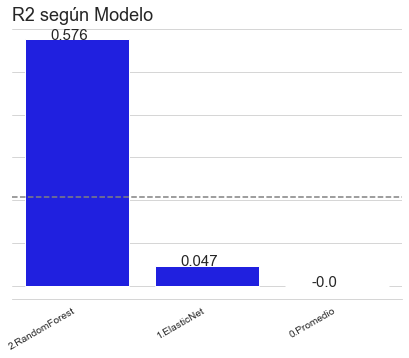

In [22]:
plt.subplots(figsize=(7, 5))
grafico_agrup(metricas_modelos.r2, "R2 según Modelo") 

Tal como podíamos esperar RandomForest es el modelo que mejor performa. Llama la atención la pobre performance de Elastic Rearch con un score muy cercano a 0

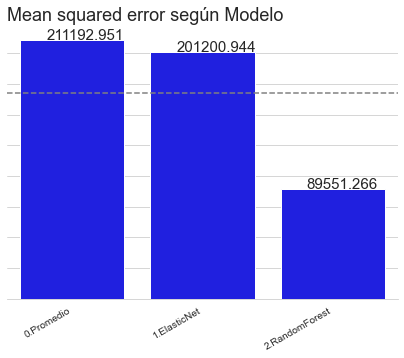

In [23]:
plt.subplots(figsize=(7, 5))
grafico_agrup(metricas_modelos.mse, "Mean squared error según Modelo")

Una posible explicación de los valores tan elevedados en esta métrica puede ser que la media haya sido atraida por valores altos extremos propios de las distribuciones con asimetría positiva como observamos en el histograma. De todas formas, se puede observar que el RandomForest performa mejor que el resto de los modelos

In [24]:
f_names = pd.DataFrame(X.select_dtypes(include=['float64', 'int64']).columns.values.tolist() + list(modelo_final_rf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names())).rename(columns={0:'name'})
f_importances = pd.DataFrame(modelo_final_rf.named_steps['reg'].feature_importances_).rename(columns={0:'importance'})
feature_importances= pd.concat([f_names, f_importances], axis=1).sort_values(by='importance', ascending=False)

feature_importances.set_index('name', inplace=True)

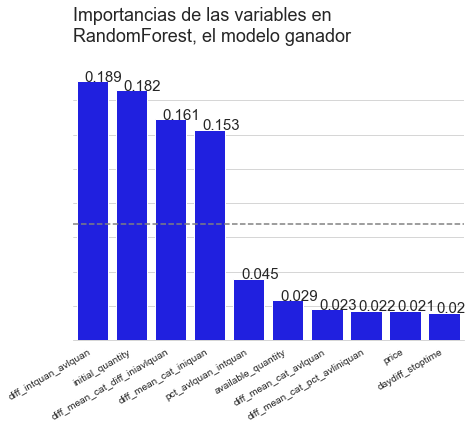

In [25]:
plt.subplots(figsize=(7, 5))
grafico_agrup(feature_importances.importance[:10], "Importancias de las variables en\nRandomForest, el modelo ganador\n") 

Como era de esperarse las features con mayor importancia son aquellas relacionadas a información disponible sobre los tipos de cantidades en cuestión

### Resultados en Test

In [26]:
modelo_final_rf.fit(X_train, y_train)
ytest_pred_rf = modelo_final_rf.predict(X_test)
metricas_test =metricas(y_test,ytest_pred_rf, 'RandomForest: TestSet')

In [27]:
metricas_test

,r2,mse
RandomForest: TestSet,0.607373,44576.438277


Observamos una performance en el testset similar, incluso un poco mejor, a la obtenida en el validationset, esto muestra la estabilidad del modelo y nos resguarda del peligro del overfitting